<a href="https://colab.research.google.com/github/devclo/Intro-To-Artificial-Intelligence/blob/Linear-Regression-and-CNN-Assignment-(Part-2)/Linear_Regression_and_CNN_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pantelis/aiml-common/blob/master/lectures/cnn/cnn-example-architectures/using_convnets_with_small_datasets.ipynb)


This notebook is by F. Chollet and is included in his book.

In [ ]:
import os
import random
import shutil
os.environ['LD_LIBRARY_PATH'] = '/workspaces/artificial_intelligence/.venv/lib/python3.11/site-packages/tensorrt_libs'

import tensorflow as tf
import keras
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


# Using convnets with small datasets

This notebook contains the code sample found in Chapter 5, Section 2 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

## Training a convnet from scratch on a small dataset

Having to train an image classification model using only very little data is a common situation, which you likely encounter yourself in
practice if you ever do computer vision in a professional context.

Having "few" samples can mean anywhere from a few hundreds to a few tens of thousands of images. As a practical example, we will focus on
classifying images as "dogs" or "cats", in a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs). We will use 2000
pictures for training, 1000 for validation, and finally 1000 for testing.

In this section, we will review one basic strategy to tackle this problem: training a new model from scratch on what little data we have. We
will start by naively training a small convnet on our 2000 training samples, without any regularization, to set a baseline for what can be
achieved. This will get us to a classification accuracy of 71%. At that point, our main issue will be overfitting. Then we will introduce
*data augmentation*, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve
our network to reach an accuracy of 82%.

In the next section, we will review two more essential techniques for applying deep learning to small datasets: *doing feature extraction
with a pre-trained network* (this will get us to an accuracy of 90% to 93%), and *fine-tuning a pre-trained network* (this will get us to
our final accuracy of 95%). Together, these three strategies -- training a small model from scratch, doing feature extracting using a
pre-trained model, and fine-tuning a pre-trained model -- will constitute your future toolbox for tackling the problem of doing computer
vision with small datasets.

## The relevance of deep learning for small-data problems

You will sometimes hear that deep learning only works when lots of data is available. This is in part a valid point: one fundamental
characteristic of deep learning is that it is able to find interesting features in the training data on its own, without any need for manual
feature engineering, and this can only be achieved when lots of training examples are available. This is especially true for problems where
the input samples are very high-dimensional, like images.

However, what constitutes "lots" of samples is relative -- relative to the size and depth of the network you are trying to train, for
starters. It isn't possible to train a convnet to solve a complex problem with just a few tens of samples, but a few hundreds can
potentially suffice if the model is small and well-regularized and if the task is simple.
Because convnets learn local, translation-invariant features, they are very
data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results
despite a relative lack of data, without the need for any custom feature engineering. You will see this in action in this section.

But what's more, deep learning models are by nature highly repurposable: you can take, say, an image classification or speech-to-text model
trained on a large-scale dataset then reuse it on a significantly different problem with only minor changes. Specifically, in the case of
computer vision, many pre-trained models (usually trained on the ImageNet dataset) are now publicly available for download and can be used
to bootstrap powerful vision models out of very little data. That's what we will do in the next section.

For now, let's get started by getting our hands on the data.

## Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision
competition in late 2013, back when convnets weren't quite mainstream. The data in the form of a zip file is stored in your course repo under the path

```lectures/cnn/cnn-example-architectures/dogs-vs-cats-subset.zip```

<!-- You can download the original dataset at:
`https://www.kaggle.com/c/dogs-vs-cats/data` (you will need to create a Kaggle account if you don't already have one -- don't worry, the
process is painless). -->

The pictures are medium-resolution color JPEGs. They look like this:

![cats_vs_dogs_samples](https://s3.amazonaws.com/book.keras.io/img/ch5/cats_vs_dogs_samples.jpg)

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to
95% accuracy. In our own example, we will get fairly close to this accuracy (in the next section), even though we will be training our
models on less than 10% of the data that was available to the competitors.
This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). After downloading
and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, a validation
set with 500 samples of each class, and finally a test set with 500 samples of each class.

Here are a few lines of code to do this:

In [ ]:
import os, shutil

In [ ]:
 !wget https://github.com/pantelis/aiml-common/raw/master/lectures/cnn/cnn-example-architectures/dogs-vs-cats-subset.zip

--2023-10-16 01:06:53--  https://github.com/pantelis/aiml-common/raw/master/lectures/cnn/cnn-example-architectures/dogs-vs-cats-subset.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/pantelis/aiml-common/master/lectures/cnn/cnn-example-architectures/dogs-vs-cats-subset.zip [following]
--2023-10-16 01:06:54--  https://raw.githubusercontent.com/pantelis/aiml-common/master/lectures/cnn/cnn-example-architectures/dogs-vs-cats-subset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90831994 (87M) [application/zip]
Saving to: ‘dogs-vs-cats-subset.zip’

dogs-vs-cats-subset 100%[==================

In [ ]:
# Unzip file
!mkdir -p dogscats/subset
!unzip -o -q dogs-vs-cats-subset.zip -d dogscats


In [ ]:
base_dir = 'dogscats/subset'
train_dir = os.path.join(base_dir, 'train')
train_cats_dir = os.path.join(base_dir, 'train', 'cats')
train_dogs_dir = os.path.join(base_dir, 'train', 'dogs')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')




So we have indeed 2000 training images, and then 1000 validation images and 1000 test images. In each split, there is the same number of
samples from each class: this is a balanced binary classification problem, which means that classification accuracy will be an appropriate
measure of success.

## Building our network

We've already built a small convnet for MNIST in the previous example, so you should be familiar with them. We will reuse the same
general structure: our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers.

However, since we are dealing with bigger images and a more complex problem, we will make our network accordingly larger: it will have one
more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the
feature maps, so that they aren't overly large when we reach the `Flatten` layer. Here, since we start from inputs of size 150x150 (a
somewhat arbitrary choice), we end up with feature maps of size 7x7 right before the `Flatten` layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is
decreasing (from 148x148 to 7x7). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a
`sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other.

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will
use binary crossentropy as our loss (as a reminder, check out the table in Chapter 4, section 5 for a cheatsheet on what loss function to
use in various situations).

In [ ]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

## Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval (as you know, neural networks prefer to deal with small input values).

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image
processing helper tools, located at `keras.preprocessing.image`. In particular, it contains the class `ImageDataGenerator` which allows to
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we
will use here.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary
labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches
indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop
at some point.

In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators
like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely, like ours does.
Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before
declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the
generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case,
batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is
allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument,
which tells the process how many batches to draw from the validation generator for evaluation.

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

<ipython-input-11-a7acfc8093a4>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
100/100 [==============================] - 15s 51ms/step - loss: 0.8861 - acc: 0.5235 - val_loss: 0.6956 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 5s 47ms/step - loss: 0.6968 - acc: 0.5505 - val_loss: 0.6793 - val_acc: 0.6170
Epoch 3/30
100/100 [==============================] - 5s 46ms/step - loss: 0.6527 - acc: 0.6305 - val_loss: 0.7058 - val_acc: 0.6200
Epoch 4/30
100/100 [==============================] - 5s 47ms/step - loss: 0.5988 - acc: 0.6850 - val_loss: 0.6279 - val_acc: 0.6610
Epoch 5/30
100/100 [==============================] - 5s 49ms/step - loss: 0.5576 - acc: 0.7190 - val_loss: 0.6813 - val_acc: 0.5870
Epoch 6/30
100/100 [==============================] - 5s 47ms/step - loss: 0.5129 - acc: 0.7450 - val_loss: 0.5529 - val_acc: 0.7150
Epoch 7/30
100/100 [==============================] - 5s 47ms/step - loss: 0.4690 - acc: 0.7830 - val_loss: 0.5518 - val_acc: 0.7080
Epoch 8/30
100/100 [==============================] - 6s 55ms/step -

It is good practice to always save your models after training:

In [ ]:
model.save('cats_and_dogs_small_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Let's plot the loss and accuracy of the model over the training and validation data during training:

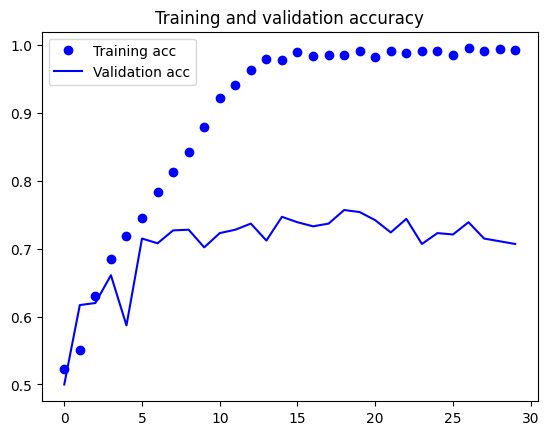

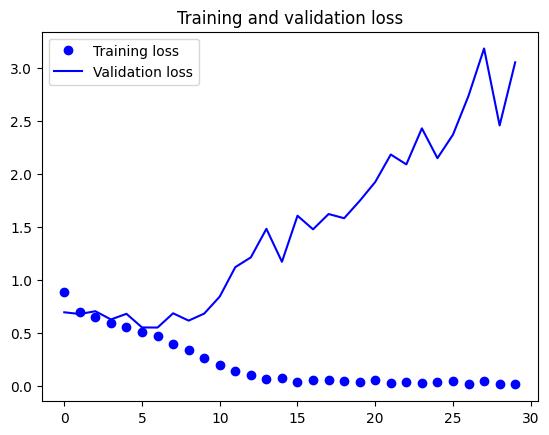

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

These plots are characteristic of overfitting. Our training accuracy increases linearly over time, until it reaches nearly 100%, while our
validation accuracy stalls at 70-72%. Our validation loss reaches its minimum after only five epochs then stalls, while the training loss
keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a
number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to
introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data
augmentation*.

## Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data.
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator`
instance. Let's get started with an example:

In [ ]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

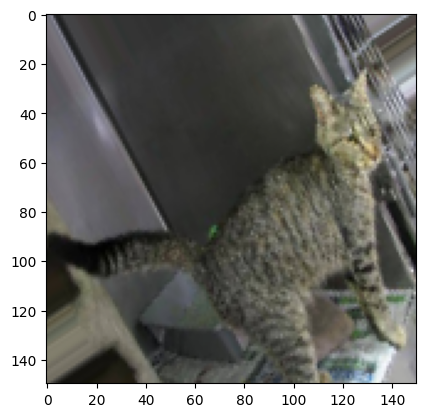

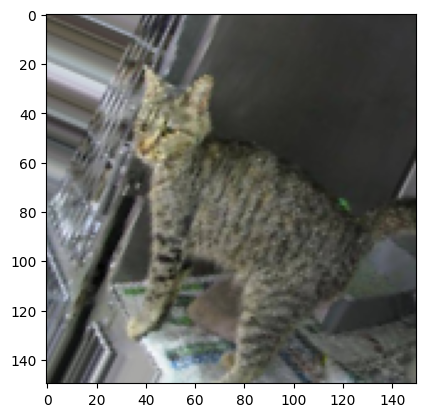

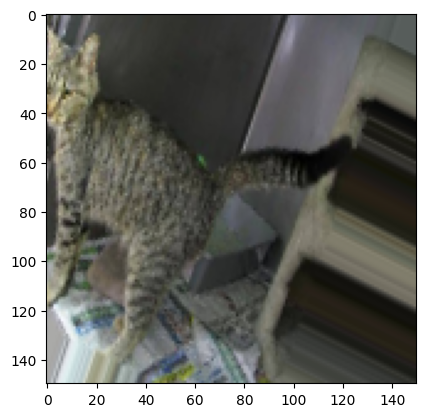

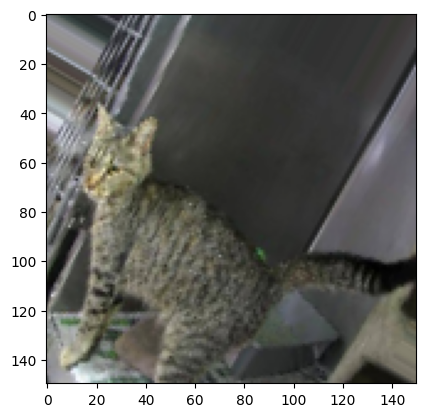

In [ ]:
# This is module with image preprocessing utilities
import keras.utils as image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(150, 150))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information,
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

Let's train our network using data augmentation and dropout:

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit(
      train_generator,
      steps_per_epoch=2000//train_generator.batch_size,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=1000//validation_generator.batch_size)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
62/62 [==============================] - 17s 241ms/step - loss: 0.6952 - acc: 0.5086 - val_loss: 0.6905 - val_acc: 0.5020
Epoch 2/100
62/62 [==============================] - 14s 233ms/step - loss: 0.6931 - acc: 0.5102 - val_loss: 0.6884 - val_acc: 0.5393
Epoch 3/100
62/62 [==============================] - 14s 223ms/step - loss: 0.6892 - acc: 0.5310 - val_loss: 0.6883 - val_acc: 0.5242
Epoch 4/100
62/62 [==============================] - 14s 224ms/step - loss: 0.6846 - acc: 0.5371 - val_loss: 0.6850 - val_acc: 0.5151
Epoch 5/100
62/62 [==============================] - 14s 222ms/step - loss: 0.6766 - acc: 0.5752 - val_loss: 0.6880 - val_acc: 0.5232
Epoch 6/100
62/62 [==============================] - 14s 230ms/step - loss: 0.6676 - acc: 0.5767 - val_loss: 0.6566 - val_acc: 0.5827
Epoch 7/100
62/62 [==============================] - 14s 223ms/step - loss: 0.6645 - acc: 0.5874 - val_loss: 0.6

Let's save our model -- we will be using it in the section on convnet visualization.

In [18]:
model.save('cats_and_dogs_small_2.model')

Let's plot our results again:

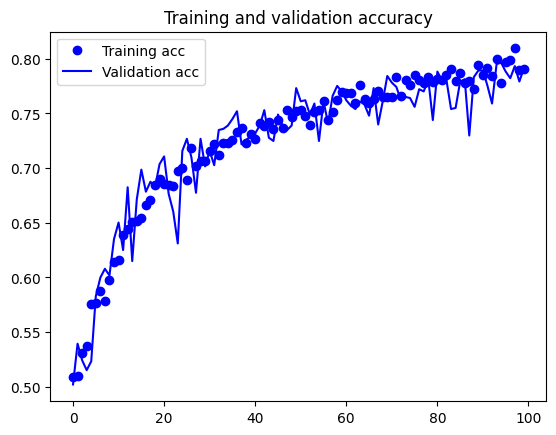

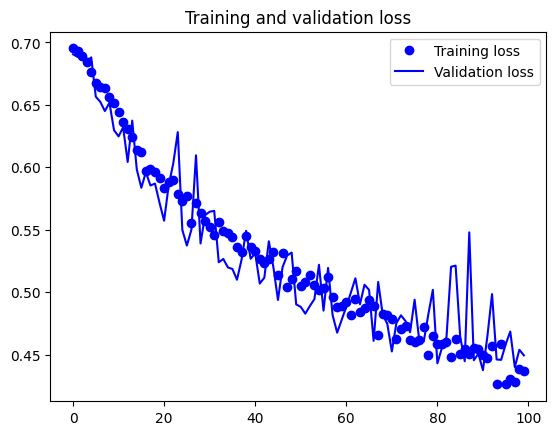

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation
curves. We are now able to reach an accuracy of 82%, a 15% relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's parameters (such as the number of filters per convolution
layer, or the number of layers in the network), we may be able to get an even better accuracy, likely up to 86-87%. However, it would prove
very difficult to go any higher just by training our own convnet from scratch, simply because we have so little data to work with. As a
next step to improve our accuracy on this problem, we will have to leverage a pre-trained model, which will be the focus of the next two
sections.


# Baseline (20 points)
You will start with this notebook and run it (you need GPU acceleration) to get baseline results for the train and test datasets after you address overfitting.

Plot the ROC curves

Plot the Recall-Precision curves

Confusion matrix for 50% threshold

Use Optuna to find the best hyperparameters for the baseline model.

Please note that you can use Pytorch for this and subsequent steps of this assignment. You need to recode the model in Pytorch though, however it is typically not very time consuming.






*   Importing the Optuna to find the best hyperparameters for the baseline model.






The objective function establishes data generators for both training and validation image datasets. These generators preprocess and load images in batches. Specifically:

Images are rescaled from [0, 255] to [0, 1] for improved model training.
Training and validation images are fetched from their respective directories, resized to 150x150 pixels, and loaded in batches of 32.
The datasets are set for binary classification tasks.



Creating/Reusing the CNN Model.

*#Notes for ME to remember#*

*   A convolutional layer with 32 filters, each of size 3x3, followed by a max-pooling layer.
*   A convolutional layer with 64 filters, followed by another max-pooling layer.
*Two consecutive convolutional layers with 128 filters each, each followed by a max-pooling layer.
*The data is then flattened to fit into fully connected layers.
*A dropout layer for regularization.
*A dense layer with 512 neurons and ReLU activation.
*A final dense layer with 1 neuron and a sigmoid activation for binary classification.





hyperparameters to be optimized:

In [20]:
!pip install optuna
import optuna
from optuna.visualization import plot_optimization_history
from keras import models, layers, optimizers
from keras.preprocessing.image import ImageDataGenerator

def objective(trial):
    # Define data generators
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

    # 1. Define hyperparameters to be optimized
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # 2. Model architecture
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.legacy.RMSprop(learning_rate=learning_rate),
                  metrics=['acc'])

    # 3. Training
    history = model.fit(
      train_generator,
      steps_per_epoch=2000 // train_generator.batch_size,
      epochs=10,  # Reduced epochs for hyperparameter tuning
      validation_data=validation_generator,
      validation_steps=1000 // validation_generator.batch_size)

    return history.history["val_acc"][-1]

def spaceout_each_trial(study, trial):
    print("\n")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, callbacks=[spaceout_each_trial])

plot_optimization_history(study)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.6 MB/s eta 0:00:00


[I 2023-10-16 01:32:06,111] A new study created in memory with name: no-name-2a59a945-b739-498a-b4a0-6f47d44120a7


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 72ms/step - loss: 0.7191 - acc: 0.5163 - val_loss: 0.6886 - val_acc: 0.6038
Epoch 2/10
62/62 [==============================] - 4s 70ms/step - loss: 0.6753 - acc: 0.5838 - val_loss: 0.6614 - val_acc: 0.5837
Epoch 3/10
62/62 [==============================] - 4s 68ms/step - loss: 0.6379 - acc: 0.6418 - val_loss: 0.6004 - val_acc: 0.6835
Epoch 4/10
62/62 [==============================] - 4s 67ms/step - loss: 0.5952 - acc: 0.6880 - val_loss: 0.5916 - val_acc: 0.6804
Epoch 5/10
62/62 [==============================] - 4s 69ms/step - loss: 0.5606 - acc: 0.7073 - val_loss: 0.6400 - val_acc: 0.6472
Epoch 6/10
62/62 [==============================] - 4s 68ms/step - loss: 0.5335 - acc: 0.7363 - val_loss: 0.6198 - val_acc: 0.6865
Epoch 7/10
62/62 [==============================] - 4s 69ms/step - loss: 0.5001 - acc: 0.7607 - val_loss: 0.5853 - val_acc: 0.6986

[I 2023-10-16 01:32:50,123] Trial 0 finished with value: 0.6925403475761414 and parameters: {'learning_rate': 0.000626423077172943, 'dropout_rate': 0.4637300952504858}. Best is trial 0 with value: 0.6925403475761414.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 72ms/step - loss: 0.7177 - acc: 0.5091 - val_loss: 0.6922 - val_acc: 0.5444
Epoch 2/10
62/62 [==============================] - 4s 69ms/step - loss: 0.6856 - acc: 0.5488 - val_loss: 0.6704 - val_acc: 0.5605
Epoch 3/10
62/62 [==============================] - 4s 69ms/step - loss: 0.6539 - acc: 0.6372 - val_loss: 0.6231 - val_acc: 0.6613
Epoch 4/10
62/62 [==============================] - 4s 68ms/step - loss: 0.5830 - acc: 0.6982 - val_loss: 0.5805 - val_acc: 0.6774
Epoch 5/10
62/62 [==============================] - 4s 68ms/step - loss: 0.5413 - acc: 0.7210 - val_loss: 0.5530 - val_acc: 0.7097
Epoch 6/10
62/62 [==============================] - 4s 68ms/step - loss: 0.5165 - acc: 0.7414 - val_loss: 0.5464 - val_acc: 0.7288
Epoch 7/10
62/62 [==============================] - 4s 70ms/step - loss: 0.4848 - acc: 0.7759 - val_loss: 0.5595 - val_acc: 0.71

[I 2023-10-16 01:33:34,280] Trial 1 finished with value: 0.7338709831237793 and parameters: {'learning_rate': 0.0005083039500524705, 'dropout_rate': 0.4432872982195941}. Best is trial 1 with value: 0.7338709831237793.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 72ms/step - loss: 0.6900 - acc: 0.5473 - val_loss: 0.6824 - val_acc: 0.5585
Epoch 2/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6703 - acc: 0.5879 - val_loss: 0.6593 - val_acc: 0.5978
Epoch 3/10
62/62 [==============================] - 4s 68ms/step - loss: 0.6535 - acc: 0.6092 - val_loss: 0.6858 - val_acc: 0.5595
Epoch 4/10
62/62 [==============================] - 4s 68ms/step - loss: 0.6379 - acc: 0.6474 - val_loss: 0.6443 - val_acc: 0.6210
Epoch 5/10
62/62 [==============================] - 4s 69ms/step - loss: 0.6214 - acc: 0.6509 - val_loss: 0.6629 - val_acc: 0.5887
Epoch 6/10
62/62 [==============================] - 4s 68ms/step - loss: 0.5981 - acc: 0.6890 - val_loss: 0.6197 - val_acc: 0.6442
Epoch 7/10
62/62 [==============================] - 4s 69ms/step - loss: 0.5704 - acc: 0.7093 - val_loss: 0.6071 - val_acc: 0.66

[I 2023-10-16 01:34:18,257] Trial 2 finished with value: 0.7086693644523621 and parameters: {'learning_rate': 6.731470990403246e-05, 'dropout_rate': 0.11260803392074958}. Best is trial 1 with value: 0.7338709831237793.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 71ms/step - loss: 0.6933 - acc: 0.5203 - val_loss: 0.6866 - val_acc: 0.5373
Epoch 2/10
62/62 [==============================] - 4s 69ms/step - loss: 0.6532 - acc: 0.6199 - val_loss: 0.6167 - val_acc: 0.6643
Epoch 3/10
62/62 [==============================] - 4s 69ms/step - loss: 0.6044 - acc: 0.6707 - val_loss: 0.5956 - val_acc: 0.6825
Epoch 4/10
62/62 [==============================] - 4s 71ms/step - loss: 0.5608 - acc: 0.7149 - val_loss: 0.5650 - val_acc: 0.7016
Epoch 5/10
62/62 [==============================] - 4s 69ms/step - loss: 0.5238 - acc: 0.7419 - val_loss: 0.5449 - val_acc: 0.7198
Epoch 6/10
62/62 [==============================] - 4s 68ms/step - loss: 0.4970 - acc: 0.7571 - val_loss: 0.5387 - val_acc: 0.7248
Epoch 7/10
62/62 [==============================] - 4s 70ms/step - loss: 0.4733 - acc: 0.7779 - val_loss: 0.5188 - val_acc: 0.73

[I 2023-10-16 01:35:02,245] Trial 3 finished with value: 0.7449596524238586 and parameters: {'learning_rate': 0.00023794518545444023, 'dropout_rate': 0.48629695389952277}. Best is trial 3 with value: 0.7449596524238586.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 70ms/step - loss: 0.6912 - acc: 0.5183 - val_loss: 0.6906 - val_acc: 0.5000
Epoch 2/10
62/62 [==============================] - 4s 67ms/step - loss: 0.6862 - acc: 0.5376 - val_loss: 0.6812 - val_acc: 0.5948
Epoch 3/10
62/62 [==============================] - 4s 70ms/step - loss: 0.6761 - acc: 0.5813 - val_loss: 0.6737 - val_acc: 0.5615
Epoch 4/10
62/62 [==============================] - 4s 69ms/step - loss: 0.6674 - acc: 0.5965 - val_loss: 0.6632 - val_acc: 0.5927
Epoch 5/10
62/62 [==============================] - 4s 68ms/step - loss: 0.6579 - acc: 0.6098 - val_loss: 0.6651 - val_acc: 0.5857
Epoch 6/10
62/62 [==============================] - 4s 70ms/step - loss: 0.6521 - acc: 0.6260 - val_loss: 0.6522 - val_acc: 0.6159
Epoch 7/10
62/62 [==============================] - 4s 68ms/step - loss: 0.6448 - acc: 0.6387 - val_loss: 0.6389 - val_acc: 0.63

[I 2023-10-16 01:35:45,984] Trial 4 finished with value: 0.625 and parameters: {'learning_rate': 3.337215239296445e-05, 'dropout_rate': 0.490502412474737}. Best is trial 3 with value: 0.7449596524238586.


In [21]:
print("Number of finished trials:", len(study.trials), "total")
print("\n")
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("\n")
print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
print("\n")
model.summary()

Number of finished trials: 5 total


Best trial:
Value:  0.7449596524238586


Params: 
    learning_rate: 0.00023794518545444023
    dropout_rate: 0.48629695389952277


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D

In [22]:

model.save('cats_and_dogs_small_best_hyper.model')

#Roc Curve, Precession-Recall, & Confusion Matrix

#ROC Curve


*  True Positive Rate (TPR) = TP / (TP + FN)
*   False Positive Rate (FPR) = FP / (FP + TN)



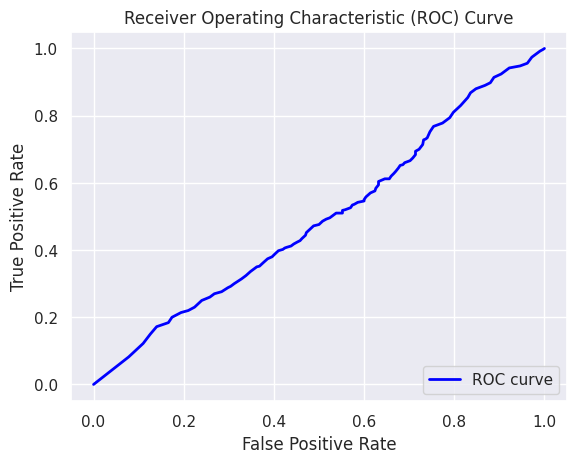

In [68]:
def compute_tpr_fpr(y_true, y_pred, threshold):
    tp = sum((y_pred > threshold) & (y_true == 1))
    tn = sum((y_pred <= threshold) & (y_true == 0))
    fp = sum((y_pred > threshold) & (y_true == 0))
    fn = sum((y_pred <= threshold) & (y_true == 1))

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    return tpr, fpr

thresholds = np.linspace(0, 1, 100)
tpr_values = []
fpr_values = []

for t in thresholds:
    tpr, fpr = compute_tpr_fpr(y_true, y_pred, t)
    tpr_values.append(tpr)
    fpr_values.append(fpr)

plt.figure()
plt.plot(fpr_values, tpr_values, color='blue', lw=2, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

#Precision-Recall


*   Precision = TP / (TP + FP)
*   Recall = TP / (TP + FN)



<ipython-input-69-0947c3aebe98>:6: RuntimeWarning:

invalid value encountered in long_scalars



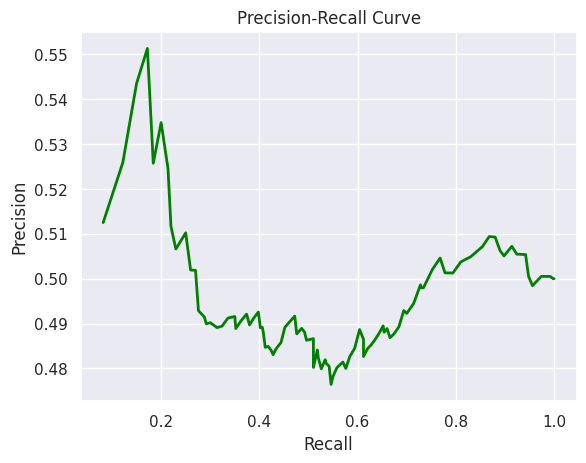

In [69]:
def compute_precision_recall(y_true, y_pred, threshold):
    tp = sum((y_pred > threshold) & (y_true == 1))
    fp = sum((y_pred > threshold) & (y_true == 0))
    fn = sum((y_pred <= threshold) & (y_true == 1))

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return precision, recall

precision_values = []
recall_values = []

for t in thresholds:
    precision, recall = compute_precision_recall(y_true, y_pred, t)
    precision_values.append(precision)
    recall_values.append(recall)

plt.figure()
plt.plot(recall_values, precision_values, color='green', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [70]:
comp_threshold = 0.5
tp = sum((y_pred > comp_threshold) & (y_true == 1))
tn = sum((y_pred <= comp_threshold) & (y_true == 0))
fp = sum((y_pred > comp_threshold) & (y_true == 0))
fn = sum((y_pred <= comp_threshold) & (y_true == 1))

#Confusion Matrix

* TP: Actual positive, Predicted positive
* TN: Actual negative, Predicted negative
* FP: Actual negative, Predicted positive
* FN: Actual positive, Predicted negative



In [71]:
print("\n")
print("Confusion Matrix at 0.50 threshold:\n", np.array([[tp, fp], [fn, tn]]))



Confusion Matrix at 0.50 threshold:
 [[267 287]
 [233 213]]


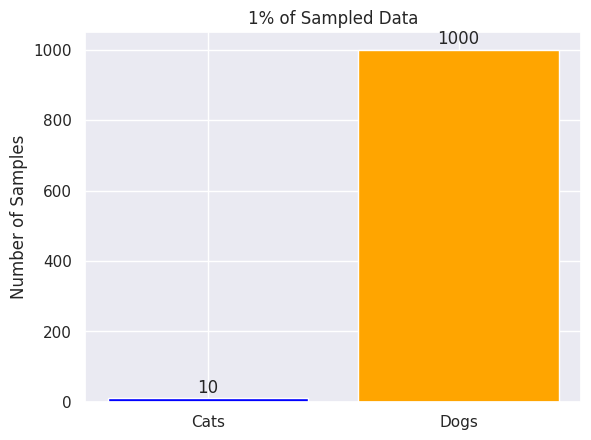

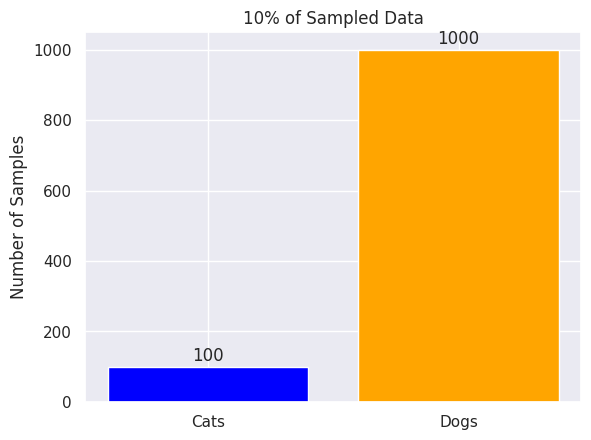

In [78]:
def delete_existing_directory(directory_path):
    if os.path.exists(directory_path) and os.path.isdir(directory_path):
        shutil.rmtree(directory_path)

def sample_rare_events(src_dir, dest_dir, rare_class_fraction):
    delete_existing_directory(dest_dir)

   # Delete existing directory before sampling, noticed duplicate data after every run.

    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # Copy all 'dogs' as they are
    dest_dogs_dir = os.path.join(dest_dir, 'dogs')
    if not os.path.exists(dest_dogs_dir):
        shutil.copytree(os.path.join(src_dir, 'dogs'), dest_dogs_dir)

    # Sample 'cats'
    all_cats = os.listdir(os.path.join(src_dir, 'cats'))
    num_cats = int(rare_class_fraction * len(all_cats))
    sampled_cats = random.sample(all_cats, num_cats)

    dest_cats_dir = os.path.join(dest_dir, 'cats')
    if not os.path.exists(dest_cats_dir):
        os.makedirs(dest_cats_dir)

    for cat in sampled_cats:
        shutil.copy(os.path.join(src_dir, 'cats', cat), os.path.join(dest_cats_dir, cat))

    return dest_dir

# Define directories
base_dir = 'dogscats/subset'
train_dir = os.path.join(base_dir, 'train')

# Sample datasets
train_1_percent = sample_rare_events(train_dir, 'data/train_1_percent', 0.01)
train_10_percent = sample_rare_events(train_dir, 'data/train_10_percent', 0.10)

# Plot function
def plot_sample_distribution(base_dir, title):
    cats_count = len(os.listdir(os.path.join(base_dir, 'cats')))
    dogs_count = len(os.listdir(os.path.join(base_dir, 'dogs')))
    labels = ['Cats', 'Dogs']
    counts = [cats_count, dogs_count]

    bars = plt.bar(labels, counts, color=['blue', 'orange'])
    plt.title(title)
    plt.ylabel('Number of Samples')

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 5, str(height),
                 ha='center', va='bottom')

    plt.show()

# Plots
plot_sample_distribution(train_1_percent, '1% of Sampled Data')
print('\n')
plot_sample_distribution(train_10_percent,'10% of Sampled Data')


In [79]:
def training_01_dataset(trial):
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_1_percent,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

    # 1. Define hyperparameters to be optimized
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # 2. Model architecture
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.legacy.RMSprop(learning_rate=learning_rate),
                  metrics=['acc'])

    # 3. Training
    history = model.fit(
      train_generator,
      steps_per_epoch=2000 // train_generator.batch_size,
      epochs=10,  # Reduced epochs for hyperparameter tuning
      validation_data=validation_generator,
      validation_steps=1000 // validation_generator.batch_size)

    return history.history["val_acc"][-1]

def spaceout_each_trial(study, trial):
    print("\n")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, callbacks=[spaceout_each_trial])

plot_optimization_history(study)

[I 2023-10-16 02:00:42,153] A new study created in memory with name: no-name-dfdfc111-d4e1-4550-a383-5e8341fc3470


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 75ms/step - loss: 0.6939 - acc: 0.4949 - val_loss: 0.6897 - val_acc: 0.5020
Epoch 2/10
62/62 [==============================] - 4s 70ms/step - loss: 0.6906 - acc: 0.5203 - val_loss: 0.6880 - val_acc: 0.5010
Epoch 3/10
62/62 [==============================] - 4s 72ms/step - loss: 0.6880 - acc: 0.5259 - val_loss: 0.6859 - val_acc: 0.6089
Epoch 4/10
62/62 [==============================] - 4s 70ms/step - loss: 0.6850 - acc: 0.5620 - val_loss: 0.6828 - val_acc: 0.6210
Epoch 5/10
62/62 [==============================] - 4s 73ms/step - loss: 0.6836 - acc: 0.5696 - val_loss: 0.6788 - val_acc: 0.5595
Epoch 6/10
62/62 [==============================] - 4s 72ms/step - loss: 0.6790 - acc: 0.5869 - val_loss: 0.6746 - val_acc: 0.5554
Epoch 7/10
62/62 [==============================] - 4s 70ms/step - loss: 0.6748 - acc: 0.5833 - val_loss: 0.6687 - val_acc: 0.6129

[I 2023-10-16 02:01:27,595] Trial 0 finished with value: 0.6239919066429138 and parameters: {'learning_rate': 1.2480142663579969e-05, 'dropout_rate': 0.47924070289942156}. Best is trial 0 with value: 0.6239919066429138.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 75ms/step - loss: 0.6952 - acc: 0.5066 - val_loss: 0.8715 - val_acc: 0.5000
Epoch 2/10
62/62 [==============================] - 4s 70ms/step - loss: 0.6790 - acc: 0.6067 - val_loss: 0.7067 - val_acc: 0.5312
Epoch 3/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6184 - acc: 0.6601 - val_loss: 0.5841 - val_acc: 0.6754
Epoch 4/10
62/62 [==============================] - 4s 70ms/step - loss: 0.5522 - acc: 0.7226 - val_loss: 0.6205 - val_acc: 0.6633
Epoch 5/10
62/62 [==============================] - 4s 70ms/step - loss: 0.5104 - acc: 0.7505 - val_loss: 0.5464 - val_acc: 0.7208
Epoch 6/10
62/62 [==============================] - 4s 72ms/step - loss: 0.4606 - acc: 0.7759 - val_loss: 0.5695 - val_acc: 0.7329
Epoch 7/10
62/62 [==============================] - 4s 71ms/step - loss: 0.4261 - acc: 0.8049 - val_loss: 0.5250 - val_acc: 0.75

[I 2023-10-16 02:02:12,652] Trial 1 finished with value: 0.7449596524238586 and parameters: {'learning_rate': 0.0006027879034635397, 'dropout_rate': 0.23162455878397023}. Best is trial 1 with value: 0.7449596524238586.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 74ms/step - loss: 0.6926 - acc: 0.5315 - val_loss: 0.6811 - val_acc: 0.5857
Epoch 2/10
62/62 [==============================] - 4s 70ms/step - loss: 0.6640 - acc: 0.5955 - val_loss: 0.6737 - val_acc: 0.5514
Epoch 3/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6141 - acc: 0.6601 - val_loss: 0.7983 - val_acc: 0.5554
Epoch 4/10
62/62 [==============================] - 4s 70ms/step - loss: 0.5766 - acc: 0.7027 - val_loss: 0.6017 - val_acc: 0.6643
Epoch 5/10
62/62 [==============================] - 4s 70ms/step - loss: 0.5557 - acc: 0.7134 - val_loss: 0.6134 - val_acc: 0.6774
Epoch 6/10
62/62 [==============================] - 4s 71ms/step - loss: 0.5285 - acc: 0.7368 - val_loss: 0.5828 - val_acc: 0.6825
Epoch 7/10
62/62 [==============================] - 4s 71ms/step - loss: 0.5008 - acc: 0.7571 - val_loss: 0.5742 - val_acc: 0.69

[I 2023-10-16 02:02:57,990] Trial 2 finished with value: 0.711693525314331 and parameters: {'learning_rate': 0.0001482632841808051, 'dropout_rate': 0.1997985376041687}. Best is trial 1 with value: 0.7449596524238586.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 6s 77ms/step - loss: 0.6917 - acc: 0.5188 - val_loss: 0.6897 - val_acc: 0.5282
Epoch 2/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6853 - acc: 0.5610 - val_loss: 0.6837 - val_acc: 0.5081
Epoch 3/10
62/62 [==============================] - 4s 69ms/step - loss: 0.6750 - acc: 0.5793 - val_loss: 0.6736 - val_acc: 0.5645
Epoch 4/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6679 - acc: 0.5945 - val_loss: 0.6651 - val_acc: 0.5998
Epoch 5/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6578 - acc: 0.6062 - val_loss: 0.6575 - val_acc: 0.6099
Epoch 6/10
62/62 [==============================] - 4s 70ms/step - loss: 0.6510 - acc: 0.6199 - val_loss: 0.6518 - val_acc: 0.6139
Epoch 7/10
62/62 [==============================] - 4s 72ms/step - loss: 0.6419 - acc: 0.6382 - val_loss: 0.6438 - val_acc: 0.62

[I 2023-10-16 02:03:43,543] Trial 3 finished with value: 0.6471773982048035 and parameters: {'learning_rate': 2.3750276368038377e-05, 'dropout_rate': 0.19523044930413436}. Best is trial 1 with value: 0.7449596524238586.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 74ms/step - loss: 0.7225 - acc: 0.5086 - val_loss: 0.6920 - val_acc: 0.5171
Epoch 2/10
62/62 [==============================] - 4s 71ms/step - loss: 0.7027 - acc: 0.5650 - val_loss: 0.6833 - val_acc: 0.5736
Epoch 3/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6679 - acc: 0.6153 - val_loss: 0.6562 - val_acc: 0.6099
Epoch 4/10
62/62 [==============================] - 4s 70ms/step - loss: 0.6365 - acc: 0.6631 - val_loss: 0.6074 - val_acc: 0.6683
Epoch 5/10
62/62 [==============================] - 4s 70ms/step - loss: 0.5723 - acc: 0.7002 - val_loss: 0.7446 - val_acc: 0.6149
Epoch 6/10
62/62 [==============================] - 4s 71ms/step - loss: 0.5494 - acc: 0.7195 - val_loss: 0.5891 - val_acc: 0.6774
Epoch 7/10
62/62 [==============================] - 4s 71ms/step - loss: 0.5186 - acc: 0.7414 - val_loss: 0.5764 - val_acc: 0.69

[I 2023-10-16 02:04:28,909] Trial 4 finished with value: 0.6834677457809448 and parameters: {'learning_rate': 0.0008790221358844745, 'dropout_rate': 0.21693700037073987}. Best is trial 1 with value: 0.7449596524238586.


In [80]:
print("Number of finished trials for %1 Sampled Data:", len(study.trials), "total")
print("\n")
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("\n")
print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
print("\n")
model.summary()

Number of finished trials for %1 Sampled Data: 5 total


Best trial:
Value:  0.7449596524238586


Params: 
    learning_rate: 0.0006027879034635397
    dropout_rate: 0.23162455878397023


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                

In [81]:

model.save('training_01_dataset.model')

In [82]:
def training_10_dataset(trial):
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_10_percent,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

    # 1. Define hyperparameters to be optimized
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-4, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # 2. Model architecture
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.legacy.RMSprop(learning_rate=learning_rate),
                  metrics=['acc'])

    # 3. Training
    history = model.fit(
      train_generator,
      steps_per_epoch=2000 // train_generator.batch_size,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=1000 // validation_generator.batch_size)

    return history.history["val_acc"][-1]

def spaceout_each_trial(study, trial):
    print("\n")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, callbacks=[spaceout_each_trial])

plot_optimization_history(study)

[I 2023-10-16 02:04:30,475] A new study created in memory with name: no-name-58055aa3-6196-4d2a-b99e-813770ff968b


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 6s 76ms/step - loss: 0.6932 - acc: 0.5142 - val_loss: 0.6889 - val_acc: 0.5000
Epoch 2/10
62/62 [==============================] - 4s 72ms/step - loss: 0.6815 - acc: 0.5584 - val_loss: 0.6833 - val_acc: 0.5121
Epoch 3/10
62/62 [==============================] - 5s 74ms/step - loss: 0.6641 - acc: 0.6077 - val_loss: 0.6657 - val_acc: 0.5736
Epoch 4/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6437 - acc: 0.6326 - val_loss: 0.6416 - val_acc: 0.6421
Epoch 5/10
62/62 [==============================] - 4s 72ms/step - loss: 0.6280 - acc: 0.6560 - val_loss: 0.6669 - val_acc: 0.5766
Epoch 6/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6073 - acc: 0.6784 - val_loss: 0.6316 - val_acc: 0.6260
Epoch 7/10
62/62 [==============================] - 4s 73ms/step - loss: 0.5904 - acc: 0.6890 - val_loss: 0.6053 - val_acc: 0.6724

[I 2023-10-16 02:05:16,418] Trial 0 finished with value: 0.6864919066429138 and parameters: {'learning_rate': 8.442019157388866e-05, 'dropout_rate': 0.4837963241076815}. Best is trial 0 with value: 0.6864919066429138.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 73ms/step - loss: 0.8957 - acc: 0.4883 - val_loss: 0.6872 - val_acc: 0.6018
Epoch 2/10
62/62 [==============================] - 4s 73ms/step - loss: 0.6985 - acc: 0.5361 - val_loss: 0.6625 - val_acc: 0.6058
Epoch 3/10
62/62 [==============================] - 4s 71ms/step - loss: 0.7058 - acc: 0.5833 - val_loss: 0.6512 - val_acc: 0.6694
Epoch 4/10
62/62 [==============================] - 4s 70ms/step - loss: 0.6525 - acc: 0.6311 - val_loss: 0.6112 - val_acc: 0.6583
Epoch 5/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6112 - acc: 0.6809 - val_loss: 0.7928 - val_acc: 0.6058
Epoch 6/10
62/62 [==============================] - 4s 71ms/step - loss: 0.5888 - acc: 0.7073 - val_loss: 0.5922 - val_acc: 0.6744
Epoch 7/10
62/62 [==============================] - 4s 71ms/step - loss: 0.5280 - acc: 0.7348 - val_loss: 0.5882 - val_acc: 0.68

[I 2023-10-16 02:06:01,936] Trial 1 finished with value: 0.7147177457809448 and parameters: {'learning_rate': 0.0009916846538661332, 'dropout_rate': 0.39738879424337614}. Best is trial 1 with value: 0.7147177457809448.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 75ms/step - loss: 0.6906 - acc: 0.5107 - val_loss: 0.6834 - val_acc: 0.5766
Epoch 2/10
62/62 [==============================] - 5s 88ms/step - loss: 0.6778 - acc: 0.5554 - val_loss: 0.6729 - val_acc: 0.5403
Epoch 3/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6651 - acc: 0.5869 - val_loss: 0.6523 - val_acc: 0.6018
Epoch 4/10
62/62 [==============================] - 4s 72ms/step - loss: 0.6529 - acc: 0.6082 - val_loss: 0.6726 - val_acc: 0.5655
Epoch 5/10
62/62 [==============================] - 5s 73ms/step - loss: 0.6458 - acc: 0.6225 - val_loss: 0.6429 - val_acc: 0.6038
Epoch 6/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6327 - acc: 0.6240 - val_loss: 0.6358 - val_acc: 0.6210
Epoch 7/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6213 - acc: 0.6428 - val_loss: 0.6247 - val_acc: 0.64

[I 2023-10-16 02:06:48,551] Trial 2 finished with value: 0.6522177457809448 and parameters: {'learning_rate': 4.8139446772506206e-05, 'dropout_rate': 0.41367259818366564}. Best is trial 1 with value: 0.7147177457809448.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 74ms/step - loss: 0.7121 - acc: 0.5107 - val_loss: 0.7059 - val_acc: 0.5010
Epoch 2/10
62/62 [==============================] - 4s 72ms/step - loss: 0.6901 - acc: 0.5620 - val_loss: 0.6717 - val_acc: 0.5081
Epoch 3/10
62/62 [==============================] - 4s 72ms/step - loss: 0.6501 - acc: 0.6189 - val_loss: 0.6819 - val_acc: 0.5948
Epoch 4/10
62/62 [==============================] - 4s 71ms/step - loss: 0.5960 - acc: 0.6814 - val_loss: 0.6040 - val_acc: 0.6744
Epoch 5/10
62/62 [==============================] - 4s 72ms/step - loss: 0.5775 - acc: 0.7088 - val_loss: 0.5608 - val_acc: 0.7147
Epoch 6/10
62/62 [==============================] - 4s 69ms/step - loss: 0.5434 - acc: 0.7190 - val_loss: 0.5620 - val_acc: 0.7137
Epoch 7/10
62/62 [==============================] - 4s 70ms/step - loss: 0.5130 - acc: 0.7480 - val_loss: 0.5684 - val_acc: 0.70

[I 2023-10-16 02:07:33,676] Trial 3 finished with value: 0.7338709831237793 and parameters: {'learning_rate': 0.0007303418154292048, 'dropout_rate': 0.4939076714604772}. Best is trial 3 with value: 0.7338709831237793.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 74ms/step - loss: 0.7397 - acc: 0.5132 - val_loss: 0.6916 - val_acc: 0.5091
Epoch 2/10
62/62 [==============================] - 4s 69ms/step - loss: 0.6990 - acc: 0.5467 - val_loss: 0.6663 - val_acc: 0.6230
Epoch 3/10
62/62 [==============================] - 4s 70ms/step - loss: 0.6808 - acc: 0.5960 - val_loss: 0.6312 - val_acc: 0.6371
Epoch 4/10
62/62 [==============================] - 4s 70ms/step - loss: 0.6304 - acc: 0.6489 - val_loss: 0.6242 - val_acc: 0.6452
Epoch 5/10
62/62 [==============================] - 4s 70ms/step - loss: 0.5805 - acc: 0.6845 - val_loss: 0.6394 - val_acc: 0.6825
Epoch 6/10
62/62 [==============================] - 4s 71ms/step - loss: 0.5491 - acc: 0.7190 - val_loss: 0.6367 - val_acc: 0.6431
Epoch 7/10
62/62 [==============================] - 4s 70ms/step - loss: 0.5507 - acc: 0.7393 - val_loss: 0.6130 - val_acc: 0.67

[I 2023-10-16 02:08:18,636] Trial 4 finished with value: 0.7147177457809448 and parameters: {'learning_rate': 0.0009196881240973404, 'dropout_rate': 0.47882099168579273}. Best is trial 3 with value: 0.7338709831237793.


In [83]:
print("Number of finished trials for %10 Sampled Data:", len(study.trials), "total")
print("\n")
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("\n")
print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
print("\n")
model.summary()

Number of finished trials for %10 Sampled Data: 5 total


Best trial:
Value:  0.7338709831237793


Params: 
    learning_rate: 0.0007303418154292048
    dropout_rate: 0.4939076714604772


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                

In [84]:

model.save('training_10_dataset.model')

#Improvement Method #1 - Focal Loss

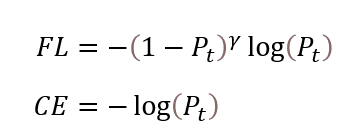

* Focal Loss is a modified version of a standard loss function used to train models. Its main idea is to give more importance to hard-to-classify examples and less importance to easy ones.
*  By adjusting the importance of different examples, Focal Loss helps in training models better on datasets where one type of example is much more common than the other.


In [98]:
def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed


In [99]:
def training_01_dataset(trial):
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_1_percent,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

    # 1. Define hyperparameters to be optimized
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # 2. Model architecture
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
  #instead of using BCE we will use focal loss

    model.compile(loss=focal_loss(),
                  optimizer=optimizers.legacy.RMSprop(learning_rate=learning_rate),
                  metrics=['acc'])

    # 3. Training
    history = model.fit(
      train_generator,
      steps_per_epoch=2000 // train_generator.batch_size,
      epochs=10,  # Reduced epochs for hyperparameter tuning
      validation_data=validation_generator,
      validation_steps=1000 // validation_generator.batch_size)

    return history.history["val_acc"][-1]

def spaceout_each_trial(study, trial):
    print("\n")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, callbacks=[spaceout_each_trial])

plot_optimization_history(study)



[I 2023-10-16 02:38:32,950] A new study created in memory with name: no-name-c91c2525-6391-411e-8c65-a7662eccb073


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 76ms/step - loss: 0.6894 - acc: 0.5193 - val_loss: 0.6711 - val_acc: 0.5363
Epoch 2/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6613 - acc: 0.5915 - val_loss: 0.6383 - val_acc: 0.6300
Epoch 3/10
62/62 [==============================] - 4s 70ms/step - loss: 0.6118 - acc: 0.6611 - val_loss: 0.6263 - val_acc: 0.6532
Epoch 4/10
62/62 [==============================] - 4s 71ms/step - loss: 0.5747 - acc: 0.6916 - val_loss: 0.6238 - val_acc: 0.6341
Epoch 5/10
62/62 [==============================] - 4s 70ms/step - loss: 0.5600 - acc: 0.7154 - val_loss: 0.5965 - val_acc: 0.6683
Epoch 6/10
62/62 [==============================] - 4s 69ms/step - loss: 0.5263 - acc: 0.7419 - val_loss: 0.6075 - val_acc: 0.6744
Epoch 7/10
62/62 [==============================] - 4s 70ms/step - loss: 0.5169 - acc: 0.7307 - val_loss: 0.5786 - val_acc: 0.6996

[I 2023-10-16 02:39:17,839] Trial 0 finished with value: 0.7106854915618896 and parameters: {'learning_rate': 0.00011795440162992555, 'dropout_rate': 0.3247283857237815}. Best is trial 0 with value: 0.7106854915618896.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 74ms/step - loss: 0.6925 - acc: 0.5097 - val_loss: 0.6913 - val_acc: 0.5000
Epoch 2/10
62/62 [==============================] - 4s 70ms/step - loss: 0.6903 - acc: 0.5188 - val_loss: 0.6892 - val_acc: 0.5020
Epoch 3/10
62/62 [==============================] - 4s 68ms/step - loss: 0.6874 - acc: 0.5452 - val_loss: 0.6866 - val_acc: 0.5101
Epoch 4/10
62/62 [==============================] - 4s 69ms/step - loss: 0.6845 - acc: 0.5793 - val_loss: 0.6835 - val_acc: 0.5464
Epoch 5/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6813 - acc: 0.5620 - val_loss: 0.6834 - val_acc: 0.5595
Epoch 6/10
62/62 [==============================] - 5s 74ms/step - loss: 0.6765 - acc: 0.6082 - val_loss: 0.6765 - val_acc: 0.5353
Epoch 7/10
62/62 [==============================] - 4s 70ms/step - loss: 0.6718 - acc: 0.6057 - val_loss: 0.6723 - val_acc: 0.55

[I 2023-10-16 02:40:03,274] Trial 1 finished with value: 0.6199596524238586 and parameters: {'learning_rate': 1.3207343325021821e-05, 'dropout_rate': 0.34377296371974486}. Best is trial 0 with value: 0.7106854915618896.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 72ms/step - loss: 0.6924 - acc: 0.5112 - val_loss: 0.6869 - val_acc: 0.5625
Epoch 2/10
62/62 [==============================] - 4s 69ms/step - loss: 0.6839 - acc: 0.5762 - val_loss: 0.6787 - val_acc: 0.5897
Epoch 3/10
62/62 [==============================] - 4s 69ms/step - loss: 0.6714 - acc: 0.6026 - val_loss: 0.6660 - val_acc: 0.5827
Epoch 4/10
62/62 [==============================] - 4s 68ms/step - loss: 0.6604 - acc: 0.6123 - val_loss: 0.6546 - val_acc: 0.5988
Epoch 5/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6482 - acc: 0.6209 - val_loss: 0.6547 - val_acc: 0.5917
Epoch 6/10
62/62 [==============================] - 4s 68ms/step - loss: 0.6374 - acc: 0.6316 - val_loss: 0.6361 - val_acc: 0.6331
Epoch 7/10
62/62 [==============================] - 4s 72ms/step - loss: 0.6257 - acc: 0.6519 - val_loss: 0.6341 - val_acc: 0.63

[I 2023-10-16 02:40:47,987] Trial 2 finished with value: 0.65625 and parameters: {'learning_rate': 2.989576593807274e-05, 'dropout_rate': 0.277346790949487}. Best is trial 0 with value: 0.7106854915618896.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 74ms/step - loss: 0.6988 - acc: 0.5086 - val_loss: 0.6878 - val_acc: 0.5252
Epoch 2/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6739 - acc: 0.5879 - val_loss: 0.6590 - val_acc: 0.6391
Epoch 3/10
62/62 [==============================] - 4s 72ms/step - loss: 0.6248 - acc: 0.6552 - val_loss: 0.6115 - val_acc: 0.6754
Epoch 4/10
62/62 [==============================] - 4s 70ms/step - loss: 0.5784 - acc: 0.6966 - val_loss: 0.6453 - val_acc: 0.6442
Epoch 5/10
62/62 [==============================] - 4s 71ms/step - loss: 0.5519 - acc: 0.7129 - val_loss: 0.5925 - val_acc: 0.6825
Epoch 6/10
62/62 [==============================] - 5s 73ms/step - loss: 0.5287 - acc: 0.7337 - val_loss: 0.5746 - val_acc: 0.6925
Epoch 7/10
62/62 [==============================] - 4s 71ms/step - loss: 0.4865 - acc: 0.7622 - val_loss: 0.6065 - val_acc: 0.70

[I 2023-10-16 02:41:33,531] Trial 3 finished with value: 0.7106854915618896 and parameters: {'learning_rate': 0.00016747320713942732, 'dropout_rate': 0.33406099840806924}. Best is trial 0 with value: 0.7106854915618896.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 6s 76ms/step - loss: 0.6988 - acc: 0.4995 - val_loss: 0.6921 - val_acc: 0.5091
Epoch 2/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6744 - acc: 0.5838 - val_loss: 0.6827 - val_acc: 0.5605
Epoch 3/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6307 - acc: 0.6540 - val_loss: 0.6058 - val_acc: 0.6522
Epoch 4/10
62/62 [==============================] - 4s 70ms/step - loss: 0.5751 - acc: 0.6855 - val_loss: 0.5874 - val_acc: 0.6694
Epoch 5/10
62/62 [==============================] - 5s 73ms/step - loss: 0.5330 - acc: 0.7251 - val_loss: 0.5546 - val_acc: 0.7137
Epoch 6/10
62/62 [==============================] - 4s 72ms/step - loss: 0.5151 - acc: 0.7475 - val_loss: 0.6482 - val_acc: 0.6512
Epoch 7/10
62/62 [==============================] - 4s 72ms/step - loss: 0.4723 - acc: 0.7724 - val_loss: 0.5374 - val_acc: 0.72

[I 2023-10-16 02:42:19,129] Trial 4 finished with value: 0.7288306355476379 and parameters: {'learning_rate': 0.0002820122057001842, 'dropout_rate': 0.3379727690639263}. Best is trial 4 with value: 0.7288306355476379.


In [101]:
print("Number of finished trials for %10 Sampled Data:", len(study.trials), "total")
print("\n")
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("\n")
print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
print("\n")
model.summary()

Number of finished trials for %10 Sampled Data: 5 total


Best trial:
Value:  0.7237903475761414


Params: 
    learning_rate: 0.00010230051793479807
    dropout_rate: 0.11766984046624365


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                              

In [100]:
def training_10_dataset(trial):
    train_datagen = ImageDataGenerator(rescale=1./255)
    validation_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_10_percent,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

    validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

    # 1. Define hyperparameters to be optimized
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-4, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # 2. Model architecture
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(loss=focal_loss(),
                  optimizer=optimizers.legacy.RMSprop(learning_rate=learning_rate),
                  metrics=['acc'])

    # 3. Training
    history = model.fit(
      train_generator,
      steps_per_epoch=2000 // train_generator.batch_size,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=1000 // validation_generator.batch_size)

    return history.history["val_acc"][-1]

def spaceout_each_trial(study, trial):
    print("\n")

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, callbacks=[spaceout_each_trial])

plot_optimization_history(study)

[I 2023-10-16 02:42:19,153] A new study created in memory with name: no-name-96d182ce-3cda-4720-9a8c-f0817a199c6c


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 73ms/step - loss: 0.6919 - acc: 0.5091 - val_loss: 0.6916 - val_acc: 0.5101
Epoch 2/10
62/62 [==============================] - 4s 69ms/step - loss: 0.6906 - acc: 0.5234 - val_loss: 0.6865 - val_acc: 0.5282
Epoch 3/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6862 - acc: 0.5579 - val_loss: 0.6826 - val_acc: 0.5786
Epoch 4/10
62/62 [==============================] - 4s 73ms/step - loss: 0.6804 - acc: 0.5884 - val_loss: 0.6767 - val_acc: 0.6179
Epoch 5/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6777 - acc: 0.5823 - val_loss: 0.6713 - val_acc: 0.6018
Epoch 6/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6690 - acc: 0.6037 - val_loss: 0.6739 - val_acc: 0.5504
Epoch 7/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6656 - acc: 0.6052 - val_loss: 0.6595 - val_acc: 0.6250

[I 2023-10-16 02:43:04,688] Trial 0 finished with value: 0.6330645084381104 and parameters: {'learning_rate': 1.6891995029015964e-05, 'dropout_rate': 0.3297621618345363}. Best is trial 0 with value: 0.6330645084381104.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 6s 83ms/step - loss: 0.6950 - acc: 0.5137 - val_loss: 0.6828 - val_acc: 0.5837
Epoch 2/10
62/62 [==============================] - 5s 72ms/step - loss: 0.6722 - acc: 0.5757 - val_loss: 0.6598 - val_acc: 0.5796
Epoch 3/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6350 - acc: 0.6484 - val_loss: 0.6588 - val_acc: 0.5867
Epoch 4/10
62/62 [==============================] - 4s 72ms/step - loss: 0.5972 - acc: 0.6687 - val_loss: 0.6233 - val_acc: 0.6401
Epoch 5/10
62/62 [==============================] - 4s 71ms/step - loss: 0.5714 - acc: 0.7002 - val_loss: 0.5991 - val_acc: 0.6724
Epoch 6/10
62/62 [==============================] - 4s 70ms/step - loss: 0.5482 - acc: 0.7221 - val_loss: 0.6027 - val_acc: 0.6714
Epoch 7/10
62/62 [==============================] - 4s 72ms/step - loss: 0.5262 - acc: 0.7353 - val_loss: 0.6094 - val_acc: 0.65

[I 2023-10-16 02:43:50,994] Trial 1 finished with value: 0.6985887289047241 and parameters: {'learning_rate': 0.00012640395900420634, 'dropout_rate': 0.3719516857551285}. Best is trial 1 with value: 0.6985887289047241.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 74ms/step - loss: 0.6873 - acc: 0.5427 - val_loss: 0.6721 - val_acc: 0.5827
Epoch 2/10
62/62 [==============================] - 5s 73ms/step - loss: 0.6647 - acc: 0.6042 - val_loss: 0.6581 - val_acc: 0.5837
Epoch 3/10
62/62 [==============================] - 4s 71ms/step - loss: 0.6442 - acc: 0.6230 - val_loss: 0.7083 - val_acc: 0.5504
Epoch 4/10
62/62 [==============================] - 4s 72ms/step - loss: 0.6117 - acc: 0.6489 - val_loss: 0.6255 - val_acc: 0.6381
Epoch 5/10
62/62 [==============================] - 5s 73ms/step - loss: 0.5805 - acc: 0.7033 - val_loss: 0.6040 - val_acc: 0.6694
Epoch 6/10
62/62 [==============================] - 4s 72ms/step - loss: 0.5605 - acc: 0.7139 - val_loss: 0.6021 - val_acc: 0.6704
Epoch 7/10
62/62 [==============================] - 5s 76ms/step - loss: 0.5360 - acc: 0.7266 - val_loss: 0.6190 - val_acc: 0.65

[I 2023-10-16 02:44:37,291] Trial 2 finished with value: 0.6713709831237793 and parameters: {'learning_rate': 9.477905009521352e-05, 'dropout_rate': 0.3193068701359507}. Best is trial 1 with value: 0.6985887289047241.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 6s 77ms/step - loss: 0.6905 - acc: 0.5274 - val_loss: 0.6829 - val_acc: 0.5514
Epoch 2/10
62/62 [==============================] - 5s 77ms/step - loss: 0.6715 - acc: 0.5955 - val_loss: 0.6686 - val_acc: 0.5756
Epoch 3/10
62/62 [==============================] - 4s 72ms/step - loss: 0.6407 - acc: 0.6448 - val_loss: 0.6294 - val_acc: 0.6613
Epoch 4/10
62/62 [==============================] - 5s 74ms/step - loss: 0.6093 - acc: 0.6845 - val_loss: 0.6139 - val_acc: 0.6542
Epoch 5/10
62/62 [==============================] - 5s 73ms/step - loss: 0.5662 - acc: 0.7193 - val_loss: 0.6715 - val_acc: 0.6018
Epoch 6/10
62/62 [==============================] - 5s 74ms/step - loss: 0.5436 - acc: 0.7236 - val_loss: 0.5658 - val_acc: 0.7036
Epoch 7/10
62/62 [==============================] - 4s 72ms/step - loss: 0.5122 - acc: 0.7495 - val_loss: 0.5767 - val_acc: 0.69

[I 2023-10-16 02:45:24,127] Trial 3 finished with value: 0.7237903475761414 and parameters: {'learning_rate': 0.00010230051793479807, 'dropout_rate': 0.11766984046624365}. Best is trial 3 with value: 0.7237903475761414.




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/10
62/62 [==============================] - 5s 75ms/step - loss: 0.7221 - acc: 0.5203 - val_loss: 0.7197 - val_acc: 0.4990
Epoch 2/10
62/62 [==============================] - 5s 73ms/step - loss: 0.6821 - acc: 0.5686 - val_loss: 0.6499 - val_acc: 0.6522
Epoch 3/10
62/62 [==============================] - 4s 73ms/step - loss: 0.6084 - acc: 0.6855 - val_loss: 0.6358 - val_acc: 0.6472
Epoch 4/10
62/62 [==============================] - 4s 71ms/step - loss: 0.5546 - acc: 0.7246 - val_loss: 0.5652 - val_acc: 0.7097
Epoch 5/10
62/62 [==============================] - 5s 73ms/step - loss: 0.5132 - acc: 0.7464 - val_loss: 0.5721 - val_acc: 0.7056
Epoch 6/10
62/62 [==============================] - 5s 73ms/step - loss: 0.4674 - acc: 0.7729 - val_loss: 0.5568 - val_acc: 0.7208
Epoch 7/10
62/62 [==============================] - 5s 73ms/step - loss: 0.4396 - acc: 0.7886 - val_loss: 0.5645 - val_acc: 0.71

[I 2023-10-16 02:46:10,480] Trial 4 finished with value: 0.7167338728904724 and parameters: {'learning_rate': 0.00037027310478167955, 'dropout_rate': 0.1796618328966474}. Best is trial 3 with value: 0.7237903475761414.


In [102]:
print("Number of finished trials for %10 Sampled Data:", len(study.trials), "total")
print("\n")
print("Best trial:")
trial = study.best_trial
print("Value: ", trial.value)
print("\n")
print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
print("\n")
model.summary()

Number of finished trials for %10 Sampled Data: 5 total


Best trial:
Value:  0.7237903475761414


Params: 
    learning_rate: 0.00010230051793479807
    dropout_rate: 0.11766984046624365


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                              